In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np
from collections import deque

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from agents.dqn_agent import Agent

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# seaborn
import seaborn as sns
sns.set()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### 1. Load the Unity Environment

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Banana_Collector.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana_Collector.app")
```

In [2]:
# loading the unity environment and setting the brain game
#env = UnityEnvironment(file_name="unity_envs/Banana_Collector.app")

## headless unity environment
env = UnityEnvironment(file_name="unity_envs/Banana_Collector_Linux_server/Banana_Collector_Linux.x86_64",worker_id=0)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: BananaLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 53
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 3, 2]
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# select brain name and brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

* Set-up: A multi-agent environment where agents compete to collect bananas.
* Goal: The agents must learn to move to as many yellow bananas as possible
  while avoiding blue bananas.
* Agents: The environment contains 5 agents linked to a single Brain.
* Agent Reward Function (independent):
  * +1 for interaction with yellow banana
  * -1 for interaction with blue banana.
* Brains: One Brain with the following observation/action space.
  * Vector Observation space: 53 corresponding to velocity of agent (2), whether
    agent is frozen and/or shot its laser (2), plus ray-based perception of
    objects around agent's forward direction (49; 7 raycast angles with 7
    measurements for each).
  * Vector Action space: (Discrete) 4 Branches:
    * Forward Motion (3 possible actions: Forward, Backwards, No Action)
    * Side Motion (3 possible actions: Left, Right, No Action)
    * Rotation (3 possible actions: Rotate Left, Rotate Right, No Action)
    * Laser (2 possible actions: Laser, No Action)
  * Visual Observations (Optional): First-person camera per-agent. Use
    `VisualBanana` scene.
* Reset Parameters: None.
* Benchmark Mean Reward: 10

Lets print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = np.array(brain.vector_action_space_size)
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: [3 3 3 2]
There are 20 agents. Each observes a state with length: 53
The state for the first agent looks like: [0.         0.         0.         1.         0.         0.
 0.02336383 0.         0.         0.         1.         0.
 0.         0.68528175 0.         0.         1.         0.
 0.         0.         0.56952494 0.         0.         0.
 1.         0.         0.         0.02488187 0.         0.
 1.         0.         0.         0.         0.53722268 0.
 0.         0.         1.         0.         0.         0.03328048
 1.         0.         0.         0.         0.         0.
 0.14436573 0.         0.         0.         0.        ]


### 3. Take Random Actions in the Environment

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                 # get the current state (for each agent)
scores = np.zeros(num_agents)                         # initialize the score (for each agent)
step=0

while True:
    actions = np.zeros(len(action_size)*num_agents)
    for i in range(num_agents):
        rand_action = np.floor(np.random.rand(len(action_size))*action_size)
        actions[i*len(action_size):(i+1)*len(action_size)] = rand_action
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.15


### 4. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# initialising the agent
agent = Agent(state_size=brain.vector_observation_space_size, action_size=np.prod(action_size),
              num_agents=num_agents,lr=1e-3,batch_size=256)

# dir for saving trained agents
model_save_path='trained_models/'

In [7]:
# check the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


Lets target a score of 10 for solving this environment
`target_score=10`

In [8]:
def action_space_decoding(encoded_action,action_size):
    decoded_action = []
    for dim in range(len(action_size)):
        num_other_poss = np.prod(action_size[dim+1:])
        decoded_action.append(encoded_action//num_other_poss)
        encoded_action = encoded_action%num_other_poss
    decoded_action = np.array(decoded_action)
    assert np.all(decoded_action<=action_size-1)
    return decoded_action

# training function
def dqn_train(max_episodes=1000,max_t=1000,target_score=10,eps_start=1.0,eps_end=1e-2,eps_decay=.995,PRINT_EVERY=100):
    """
    trains the DQN agent

    Params
    ======
    max_episodes : max number of episodes for training the agent
    max_t : max number of timesteps for each episode to be used in training
    eps_start : starting value of epsilon
    eps_end : final value of epsilon
    eps_decay : epsilon deacy rate

    """
    eps = eps_start
    
    episode_rewards_window = deque(maxlen=100)
    episode_rewards = []
    online_rewards = np.zeros(num_agents)
    
    for episode_count in range(1,max_episodes+1):

        # reset env state
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        
        for t in range(max_t):
            
            #print (episode_count,t,agent.memory.tree.n_entries)
            # choose action using the local q-network
            action = agent.act(state,eps)
            
            # decoding action
            decoded_action = []
            for i in range(num_agents):
                decoded_action.append(action_space_decoding(action[i],action_size))
            decoded_action = np.concatenate(decoded_action)
            
            # taking action in the env
            env_info = env.step(vector_action=decoded_action)[brain_name]

            # getting next_state,reward,done from the env
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)
            done = np.array(env_info.local_done)
            
            if np.max(reward) is np.nan:
                print("prob")
            
            # using agent to perform a learning step and save the sample in the memory
            agent.step(state,action,reward,next_state,done)

            # decay the epsilon value
            eps = max(eps_decay*eps,eps_end)

            # set current state = next_state
            state = next_state
            
            online_rewards += reward
            for i, terminal in enumerate(done):
                if done[i]:
                    episode_rewards.append(online_rewards[i])
                    episode_rewards_window.append(online_rewards[i])
                    online_rewards[i] = 0
            
            if np.any(done):
                break
                
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(episode_rewards_window)), end="")
        if episode_count % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(episode_rewards_window)))

        if np.mean(episode_rewards_window) > target_score:
            print('\rLearning completed in {} episodes ... Avg_score :{}'.format(episode_count, np.mean(episode_rewards_window)))
            torch.save(agent.qnet_local.state_dict(), model_save_path+'dqn_local.pth')
            break

    return episode_rewards

In [9]:
# train the dqn
scores = dqn_train(max_episodes=1000,PRINT_EVERY=10)

Episode 10	Average Score: 1.34
Learning completed in 19 episodes ... Avg_score :10.91


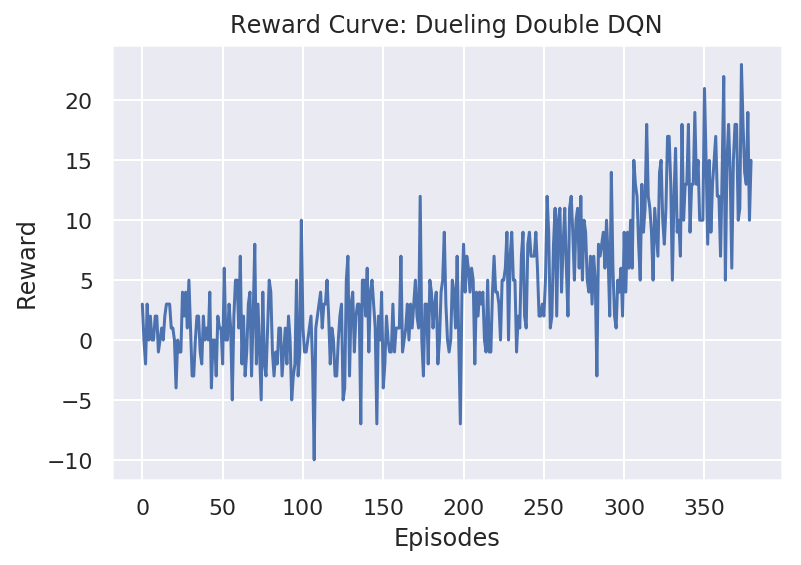

In [12]:
# plot the avg reward curve
fig = plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward Curve: Dueling Double DQN')
plt.savefig('images/reward_curve-ddqn.png',dpi=300)
plt.show()

### 5. Watch the trained RL agent!

In [ ]:
# # uncomment this cell to load trained agent weights
# # initialising the agent
# agent = Agent(state_size=brain.vector_observation_space_size, action_size=np.prod(action_size),num_agents=num_agents)
# agent.qnet_local.load_state_dict(torch.load(model_save_path+'dqn_local.pth',map_location=device))

In [13]:
# lets visualise at how the trained agent performs

# reset env state
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations

online_rewards = np.zeros(num_agents)

while True:
    # choose action using the local q-network
    action = agent.act(state,eps=0)

    # decoding action
    decoded_action = []
    for i in range(num_agents):
        decoded_action.append(action_space_decoding(action[i],action_size))
    decoded_action = np.concatenate(decoded_action)

    # taking action in the env
    env_info = env.step(vector_action=decoded_action)[brain_name]

    # getting next_state,reward,done from the env
    next_state = env_info.vector_observations
    reward = np.array(env_info.rewards)
    done = np.array(env_info.local_done)
    
    if np.max(reward) is np.nan:
        print ("prob")
    
    # set current state = next_state
    state = next_state

    online_rewards += reward

    if np.any(done):
        break
        
print ("Avg reward for episode: {:.2f}".format(np.mean(online_rewards)))

Avg reward for episode: 10.80


In [14]:
# close the unity environment
env.close()